# Atividade 01 – Modelo Linear de Alto-falante

Neste notebook, será analisado o comportamento de um alto-falante a partir de um sinal de entrada de áudio (`TC02-in.wav`). Serão apresentados os sinais no domínio do tempo e da frequência, bem como a resposta do sistema para corrente, deslocamento e aceleração. A aceleração será comparada com o sinal de entrada, e o resultado final será exportado em áudio (`TC02-out1.wav`) para análise.


In [1]:
# =============================================================================
# Importações e configurações iniciais
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d, splrep, splev

In [2]:
# =============================================================================
# Seção 1: Definição dos Parâmetros do Sistema e Modelo de Espaço de Estados
# =============================================================================
# Parâmetros físicos do alto-falante
m  = 14.35e-3   # Massa (kg)
b  = 0.786      # Amortecimento (kg/s)
k  = 1852       # Rigidez (N/m)
Bl = 4.95       # Constante eletromagnética (N/A)
L  = 266e-6     # Indutância (H)
R  = 3.3        # Resistência (Ω)

# O sistema é definido com estado x = [i, x, v]:
# - i: corrente;
# - x: deslocamento (posição do cone);
# - v: velocidade.
# Condições iniciais: [0, 0, 0].

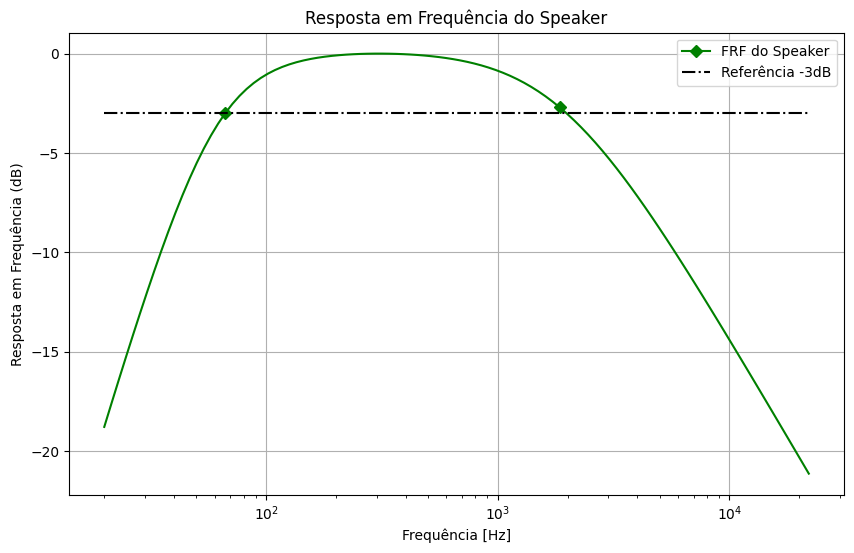

f_min (Hz) = 66.5716537441203
f_max (Hz) = 1850.0473448156674
Largura de banda (Hz) = 1783.475691071547


In [3]:
# =============================================================================
# Seção 2: Cálculo da Resposta em Frequência via Modelo Linear
# =============================================================================
# Parâmetros da malha de frequência
fmin    = 20      # Frequência mínima (Hz)
fmax    = 22e3    # Frequência máxima (Hz)
npoints = 100     # Número de pontos da malha
f       = np.logspace(np.log10(fmin), np.log10(fmax), npoints)
omega   = 2 * np.pi * f

# Matrizes do modelo de espaço de estados
# Estado: x = [i, x, v] onde:
#   i: corrente
#   x: posição do cone
#   v: velocidade do cone
A = np.array([[-R/L,    0,   -Bl/L],
              [   0,    0,       1],
              [Bl/m, -k/m,    -b/m]])
B = np.array([1/L, 0, 0])
C = np.array([0, 0, 1])
I = np.eye(3)

# Cálculo da função de transferência G(jω) para cada frequência
G = np.zeros(npoints, dtype=complex)
for i in range(npoints):
    aux  = np.linalg.inv(1j * omega[i] * I - A)
    aux2 = np.dot(aux, B)
    G[i] = np.dot(C, aux2)

# Relação para a aceleração: x¨(jω) = jω * G(jω)
FRF = 20 * np.log10(np.abs(1j * omega * G))
FRF = FRF - np.max(FRF)  # Normaliza para 0 dB (referência de pico)

# Determina a largura de banda, considerando a faixa acima de -3 dB
indices_BW = np.flatnonzero(FRF > -3)
fc_min = f[indices_BW[0]]
fc_max = f[indices_BW[-1]]
BW     = fc_max - fc_min

# Plot da Resposta em Frequência do Speaker (modelo)
markers_on = [indices_BW[0], indices_BW[-1]]
plt.figure(figsize=(10, 6))
plt.semilogx(f, FRF, '-gD', markevery=markers_on, label="FRF do Speaker")
plt.semilogx([fmin, fmax], [-3, -3], '-.k', label="Referência -3dB")
plt.xlabel('Frequência [Hz]')
plt.ylabel('Resposta em Frequência (dB)')
plt.title('Resposta em Frequência do Speaker')
plt.legend(loc="best")
plt.grid(True)
plt.show()

print('f_min (Hz) =', fc_min)
print('f_max (Hz) =', fc_max)
print('Largura de banda (Hz) =', BW)

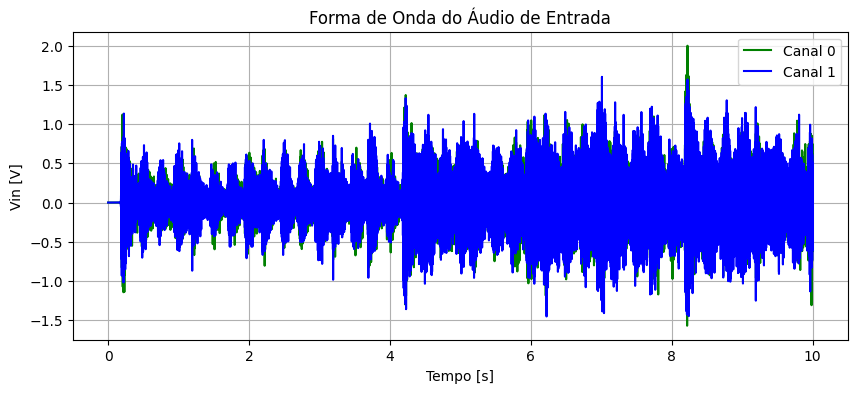

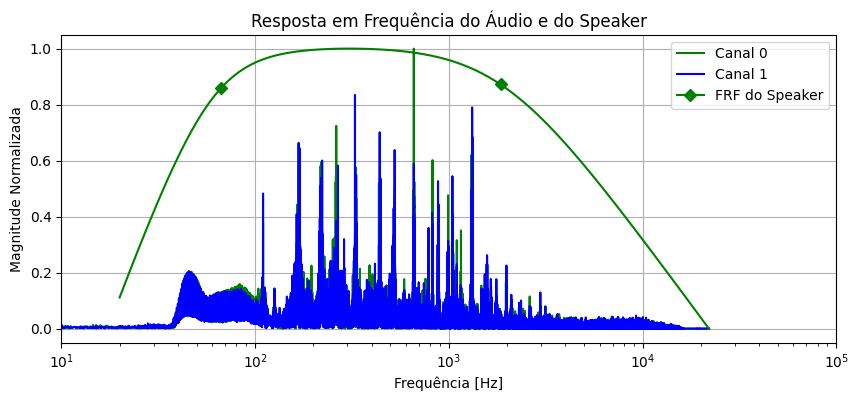

In [4]:
# =============================================================================
# Seção 3: Processamento do Áudio de Entrada (TC02-in.wav)
# =============================================================================
# Carrega o arquivo de áudio
sample_rate, data = wavfile.read('TC02-in.wav')

# Cria o vetor temporal a partir do número de amostras e da taxa de amostragem
num_samples = len(data)
duration    = num_samples / sample_rate
time        = np.linspace(0, duration, num_samples)

# Se o áudio for estéreo, separa os canais (Canal 0 e Canal 1)
if data.ndim > 1:
    CH0 = data[:, 0]  # Canal 0
    CH1 = data[:, 1]  # Canal 1
else:
    CH0 = data
    CH1 = data

# Normaliza as amplitudes para amplitude máxima de 2 V
CH_max = np.max(np.abs(data))
CH0 = 2.0 * CH0 / CH_max
CH1 = 2.0 * CH1 / CH_max

# Plot da forma de onda do áudio de entrada: Vin(t)
plt.figure(figsize=(10, 4))
plt.plot(time, CH0, 'g', label='Canal 0')
plt.plot(time, CH1, 'b', label='Canal 1')
plt.xlabel("Tempo [s]")
plt.ylabel("Vin [V]")
plt.title("Forma de Onda do Áudio de Entrada")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Cálculo da Transformada de Fourier (FFT) dos canais do áudio
N = len(CH0)
frequencies_fft = np.fft.fftfreq(N, d=1/sample_rate)
fft_CH0 = np.fft.fft(CH0)
fft_CH1 = np.fft.fft(CH1)
magnitude_CH0 = np.abs(fft_CH0)
magnitude_CH1 = np.abs(fft_CH1)
CH_max_fft = max(np.max(magnitude_CH0), np.max(magnitude_CH1))

# Para comparação, normaliza e plota o FRF do alto-falante
FRF_normalizado = (FRF - np.min(FRF)) / np.max(FRF - np.min(FRF))
plt.figure(figsize=(10, 4))
plt.semilogx(frequencies_fft[:N // 2], magnitude_CH0[:N // 2] / CH_max_fft, 'g', label='Canal 0')
plt.semilogx(frequencies_fft[:N // 2], magnitude_CH1[:N // 2] / CH_max_fft, 'b', label='Canal 1')
plt.semilogx(f, FRF_normalizado, '-gD', markevery=markers_on, label="FRF do Speaker")
plt.title('Resposta em Frequência do Áudio e do Speaker')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude Normalizada')
plt.xlim(10, 1e5)
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [5]:
# =============================================================================
# Seção 4: Simulação da Resposta do Sistema (Modelo Dinâmico)
# =============================================================================
# Cria funções interpoladoras para os sinais de entrada do áudio
ch0 = interp1d(time, CH0, kind='linear', fill_value="extrapolate")
ch1 = interp1d(time, CH1, kind='linear', fill_value="extrapolate")

# Define as equações do sistema via espaço de estados
def fch0(t, x):
    return A.dot(x) + B * ch0(t)

def fch1(t, x):
    return A.dot(x) + B * ch1(t)

# Resolução numérica das equações diferenciais com condição inicial nula
sol_CH0 = solve_ivp(fch0, [0, duration], [0, 0, 0], t_eval=time)
# Para efeito de teste rápido, usamos a mesma resposta para o Canal 1
sol_CH1 = sol_CH0

# Cálculo da aceleração do cone a partir das variáveis de estado
# x¨(t) = (Bl/m)*i - (k/m)*x - (b/m)*v
aceleracao_CH0 = (Bl/m) * sol_CH0.y[0, :] - (k/m) * sol_CH0.y[1, :] - (b/m) * sol_CH0.y[2, :]
aceleracao_CH1 = (Bl/m) * sol_CH1.y[0, :] - (k/m) * sol_CH1.y[1, :] - (b/m) * sol_CH1.y[2, :]

# Interpola a aceleração para ajustar à grade de tempo original
acc_CH0_interp = splev(time, splrep(sol_CH0.t, aceleracao_CH0))
acc_CH1_interp = splev(time, splrep(sol_CH1.t, aceleracao_CH1))

In [6]:
# =============================================================================
# Seção 5: Salvamento do Áudio de Saída (Aceleração do Cone)
# =============================================================================
# Cria sinal estéreo com os dois canais de aceleração e normaliza para evitar saturação
sinal_stereo = np.column_stack((acc_CH0_interp, acc_CH1_interp))
sinal_stereo = sinal_stereo / np.max(np.abs(sinal_stereo))
wavfile.write('TC02-out1.wav', sample_rate, sinal_stereo.astype(np.float32))

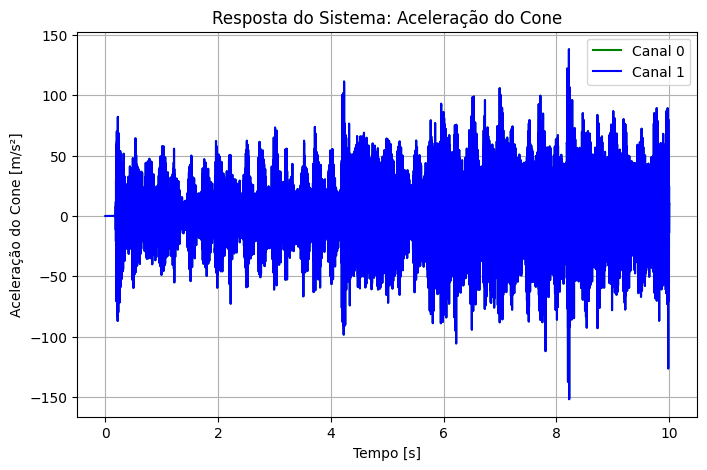

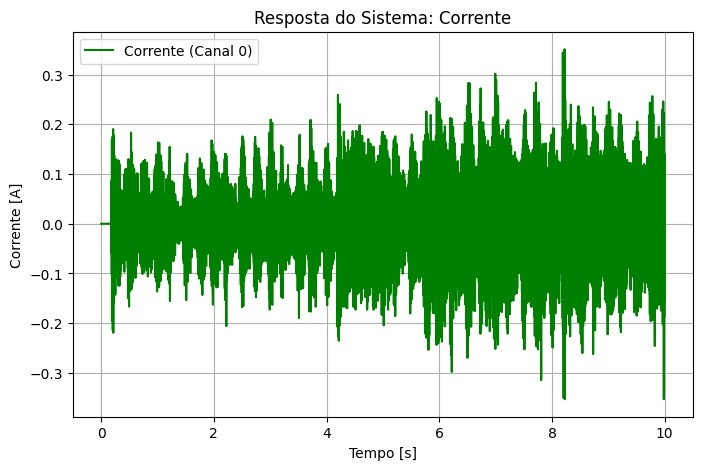

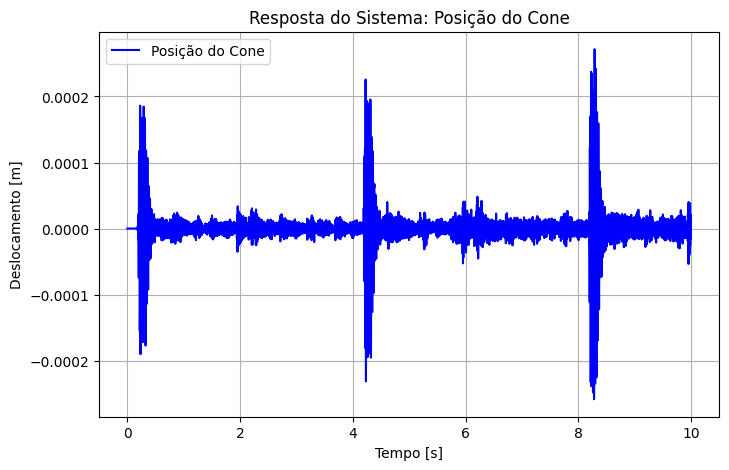

Deslocamento máximo (positivo) em CH1: 0.00027148858093880836
Excursão máxima (valor absoluto) em CH1: 0.00027148858093880836


In [7]:
# =============================================================================
# Seção 6: Plots da Resposta do Sistema
# =============================================================================
# Plot da aceleração do cone (x¨(t))
plt.figure(figsize=(8, 5))
plt.plot(time, acc_CH0_interp, 'g', linewidth=1.5, label='Canal 0')
plt.plot(time, acc_CH1_interp, 'b', linewidth=1.5, label='Canal 1')
plt.xlabel("Tempo [s]")
plt.ylabel("Aceleração do Cone [m/s²]")
plt.title("Resposta do Sistema: Aceleração do Cone")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Plot da corrente i(t)
plt.figure(figsize=(8, 5))
plt.plot(sol_CH0.t, sol_CH0.y[0, :], 'g', linewidth=1.5, label='Corrente (Canal 0)')
plt.xlabel("Tempo [s]")
plt.ylabel("Corrente [A]")
plt.title("Resposta do Sistema: Corrente")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Plot da posição do cone (x(t))
plt.figure(figsize=(8, 5))
plt.plot(sol_CH0.t, sol_CH0.y[1, :], 'b', linewidth=1.5, label='Posição do Cone')
plt.xlabel("Tempo [s]")
plt.ylabel("Deslocamento [m]")
plt.title("Resposta do Sistema: Posição do Cone")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Impressão dos valores de deslocamento máximo (canal 1)
x_CH1     = sol_CH1.y[1, :]
x_max     = np.max(x_CH1)            # Máximo deslocamento positivo
x_abs_max = np.max(np.abs(x_CH1))      # Excursão máxima (valor absoluto)
print("Deslocamento máximo (positivo) em CH1:", x_max)
print("Excursão máxima (valor absoluto) em CH1:", x_abs_max)


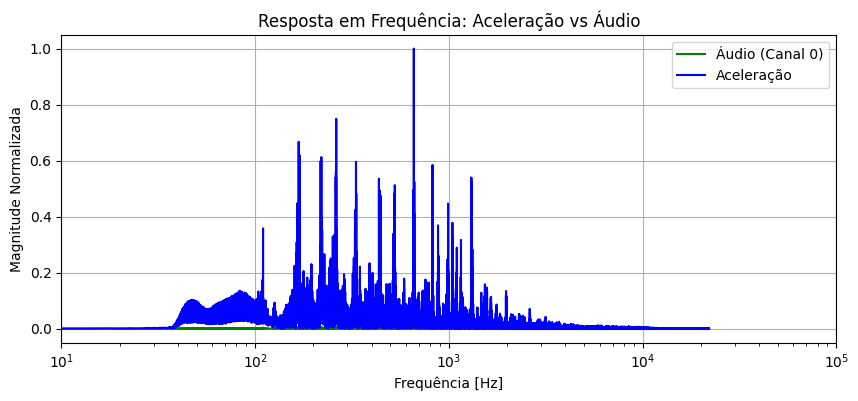

In [8]:
# =============================================================================
# Seção 7: Análise da Resposta em Frequência da Aceleração
# =============================================================================
# Cálculo da FFT da aceleração do canal 0 (x¨(jω))
N_acc = len(acc_CH0_interp)
frequencies_acc = np.fft.fftfreq(N_acc, d=1/sample_rate)
fft_acc = np.fft.fft(acc_CH0_interp)
magnitude_acc = np.abs(fft_acc)
magnitude_acc[0] = 0  # Remove a componente DC

CH_max_fft_acc = np.max(magnitude_acc)

plt.figure(figsize=(10, 4))
plt.semilogx(frequencies_acc[:N_acc//2], magnitude_CH0[:N_acc//2] / CH_max_fft_acc, 'g', label='Áudio (Canal 0)')
plt.semilogx(frequencies_acc[:N_acc//2], magnitude_acc[:N_acc//2] / CH_max_fft_acc, 'b', label='Aceleração')
plt.title('Resposta em Frequência: Aceleração vs Áudio')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude Normalizada')
plt.xlim(10, 1e5)
plt.legend(loc="best")
plt.grid(True)
plt.show()